# Basic LazyESN Usage

Tutorial on using the distributed LazyESN class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dask.array as darray
import xarray as xr

from ddc import DataLorenz96

In [2]:
from xesn import LazyESN, from_zarr

In [3]:
plt.style.use("./xesn.mplstyle")

In [5]:
data = DataLorenz96(system_dimension=64)
# spinup the dynamics
data.generate(n_steps=2_000)
# generate the training data
data.generate(n_steps=42_000)
xda = data.to_xda()

In [6]:
ldata = darray.from_array(data.values, chunks=(4,-1), asarray=False)
xda = xr.DataArray(
    ldata,
    coords=xda.coords,
    dims=xda.dims,
    attrs=xda.attrs,
)

In [10]:
esn = LazyESN(
    esn_chunks=dict(zip(xda.dims,ldata.chunksize)),
    n_reservoir=500,
    overlap={"x":2, "time":0},
    boundary="periodic",
    persist=True,
    input_factor=0.863,
    adjacency_factor=0.713,
    connectedness=5,
    bias=1.76,
    leak_rate=0.874,
    tikhonov_parameter=6.9e-7,
    input_kwargs={
        "normalization": "svd",
        "random_seed": 0,
    },
    adjacency_kwargs={
        "random_seed": 1,
    },
    bias_kwargs={
        "random_seed": 2,
    },
)

In [11]:
esn

LazyESN
    n_input:                8
    n_output:               4
    n_reservoir:            500
--- 
    connectedness:          5
    bias:                   1.76
    leak_rate:              0.874
    tikhonov_parameter:     6.9e-07
--- 
    Input Matrix:
        factor              0.863
        distribution        uniform
        normalization       svd
        is_sparse           False
        random_seed         0
--- 
    Adjacency Matrix:
        factor              0.713
        density             0.01
        distribution        uniform
        normalization       eig
        is_sparse           True
        format              csr
        random_seed         1
--- 
    overlap:
        x2
        time0
--- 
    ndim_state:             1
    input_chunks:           {'x': 8, 'time': 42000}
    output_chunks:          {'x': 4, 'time': 42000}
    r_chunks:               (500,)
    Wout_chunks:            (4, 500)
--- 
    boundary:               periodic
    persist:        

In [12]:
esn.build()

In [14]:
%%time
esn.train(xda, batch_size=10_000)

CPU times: user 1min 12s, sys: 39.3 s, total: 1min 51s
Wall time: 40.3 s


In [15]:
esn.Wout

dask.array<_train_nd, shape=(4, 8000), dtype=float64, chunksize=(4, 500), chunktype=numpy.ndarray>

In [16]:
xds = esn.test(xda, n_steps=500, n_spinup=500)

Only plot the first 6 dimensions

[Text(0.5, 0, 'Forecast Time (MTU)')]

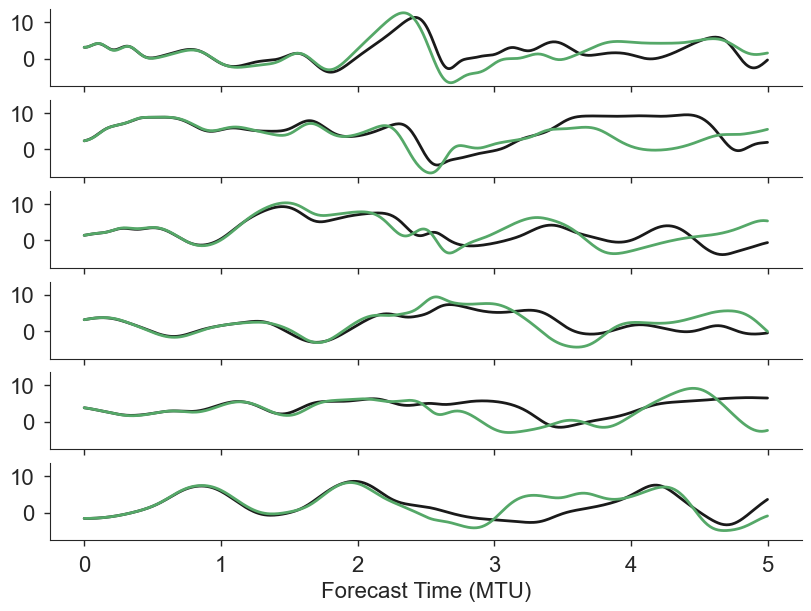

In [17]:
nrows = 6
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for i, ax in enumerate(axs):
    xds["truth"].isel(x=i).plot(ax=ax, color="k")
    xds["prediction"].isel(x=i).plot(ax=ax)
    ax.set(xlabel="", ylabel="", title="")
ax.set(xlabel="Forecast Time (MTU)")

## Save and re-load

In [18]:
ds = esn.to_xds()
ds.to_zarr("test.zarr")

In [19]:
esn2 = from_zarr("test.zarr")

In [21]:
y2 = esn2.predict(xda, n_steps=500, n_spinup=500)

In [22]:
np.abs(xds["prediction"]-y2).max().compute()

<xarray.DataArray ()>
array(0.)

In [23]:
from shutil import rmtree

In [24]:
rmtree("test.zarr")